<font size="6">**Оптимизация расходов металлургического комбината**</font>

---

# План исследовния

 [Описание проекта](#s1)

 [Исследование данных:](#s2)
  - [df_arc — об электродах](#s3)
  - [df_bulk — объём сыпучих материалов](#s4)
  - [df_bulk_time — df_bulk_time — время подачи сыпучих материалов](#s5)
  - [df_gas — продувка сплава газом](#s6)
  - [df_temp — измерения температуры](#s7)
  - [df_wire — объём проволочных материалов](#s8)
  - [df_wire_time — время подачи проволочных материалов](#s9)
  - [Выводы по исследованию](#s10)

[Предобработка данных:](#s11)
  - [Обработка пропусков](#s13)
  - [Удаление аномалий](#s12)
  - [Подготовка данных](#s14)
  - [Мультиколлинеарность](#s15)
  - [Итоги предобработки](#s16)

[Модели:](#s17)
  - [Выборки](#s18)
  - [Подбор модели](#s19)
  - [Анализ важности признаков](#s20)
  - [Итог](#s21)

[Тестирование модели](#s22)

[Выводы](#s23)



---

# Описание проекта
<a name="s1"></a>
<font size="4">Задача: </font><br> Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам необходимо построить модель, которая предскажет температуру стали.

<font size="4">Описание этапа обработки: </font>
- > Сталь обрабатывают в металлическом ковше и подогревают до нужной температуры графитовыми электродами.
- > Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.
- > Потом температуру на несколько минут повышают, производится десульфурация, добавляют легирующие материалы — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат и продувают сплав инертным газом.

- > Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

- > Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

<font size="4">Описание данных: </font>
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии.

---

In [207]:
# установка библиотек необходимых версий
!pip install pandas==1.5.3
!pip install seaborn==0.12.2
!pip install matplotlib==3.7.1

!pip install shap

In [208]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lightgbm import LGBMRegressor

import shap

pd.options.mode.chained_assignment = None

---

# Исследование даных
<a name="s2"></a>

In [209]:
# монтирование Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/My Drive/git_projects/1_melting_steel'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data_arc_new.csv	data_gas_new.csv   data_wire_time_new.csv
data_bulk_new.csv	data_temp_new.csv  steel_temperature.ipynb
data_bulk_time_new.csv	data_wire_new.csv


In [210]:
# загрузка данных
df_arc = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_arc_new.csv')
df_bulk = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_bulk_new.csv')
df_bulk_time = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_bulk_time_new.csv')
df_gas = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_gas_new.csv')
df_temp = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_temp_new.csv')
df_wire = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_wire_new.csv')
df_wire_time = pd.read_csv('drive/My Drive/git_projects/1_melting_steel/data_wire_time_new.csv')

In [211]:
# создадим функцию 'about_df()'
# передав в функцию датасет, получим информацию о нем
def about_df(df, hist_size=(8,4), hist_xrot=0):
    print('Выведем первые 5 строк:')
    print('-----------------------')
    display(df.head())
    print()
    print('-----------------------')
    print('Выведем общую информацию:')
    print('-----------------------')
    display(df.info())
    print()
    print('-----------------------')
    print('Пропуски в столбцах:')
    print('-----------------------')
    display(df.isna().sum())
    print()
    print('-----------------------')
    print('Дубликаты в данных:')
    print('-----------------------')
    display(df.duplicated().sum())
    print()
    if df.select_dtypes(['int64', 'float64']).columns.value_counts().sum() > 1:
        print('-----------------------')
        print('Описание значений по столбцам:')
        print('-----------------------')
        display(df.drop(columns='key').describe())
        print()
    if df.select_dtypes(['int64', 'float64']).columns.value_counts().sum() > 2:
        print('-----------------------')
        print('Корреляция признаков:')
        print('-----------------------')
        plt.figure(figsize = (5,5))
        sns.heatmap(df.drop(columns='key').corr(numeric_only=True),linewidth=.5)
        plt.show()
    if df.select_dtypes(['int64', 'float64']).columns.value_counts().sum() > 1:
        print()
        print('-----------------------')
        print('Распределение значений признаков:')
        print('-----------------------')
        df.drop(columns='key').hist(figsize=hist_size, xrot=hist_xrot, alpha=0.8, ec='k')
        plt.show()

In [212]:
# названия колонок к "змеиному регистру".
df_list = [df_bulk, df_bulk_time, df_wire , df_wire_time, df_arc, df_gas, df_temp]

for df in df_list:
    for i in df.columns:
        df.columns = df.columns.str.replace(i, i.replace(' ', '_').lower())

df_arc.columns = ['key', 'start_heating', 'stop_heating', 'active_power', 'reactive_power']
df_gas.columns = ['key', 'gas']
df_temp.columns = ['key', 'time', 'temperature']

In [213]:
# преобразуем колонки с датой в формат 'datetime'
for df in df_list:
    df[df.select_dtypes('object').columns] = pd.to_datetime(
        df[df.select_dtypes('object').columns].stack()).unstack()

Узнаем первичную информацию о данных, выведем первые строки, тип признаков, распределение значений, пропуски, дубликаты.

## df_arc — об электродах
<a name="s3"></a>

Выведем первые 5 строк:
-----------------------


,key,start_heating,stop_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   stop_heating    14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None


-----------------------
Пропуски в столбцах:
-----------------------


key               0
start_heating     0
stop_heating      0
active_power      0
reactive_power    0
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0


-----------------------
Описание значений по столбцам:
-----------------------


,active_power,reactive_power
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284



-----------------------
Корреляция признаков:
-----------------------


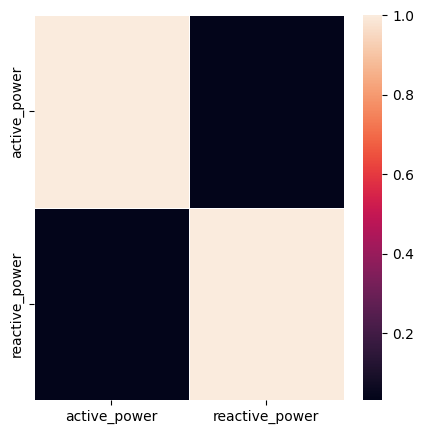


-----------------------
Распределение значений признаков:
-----------------------


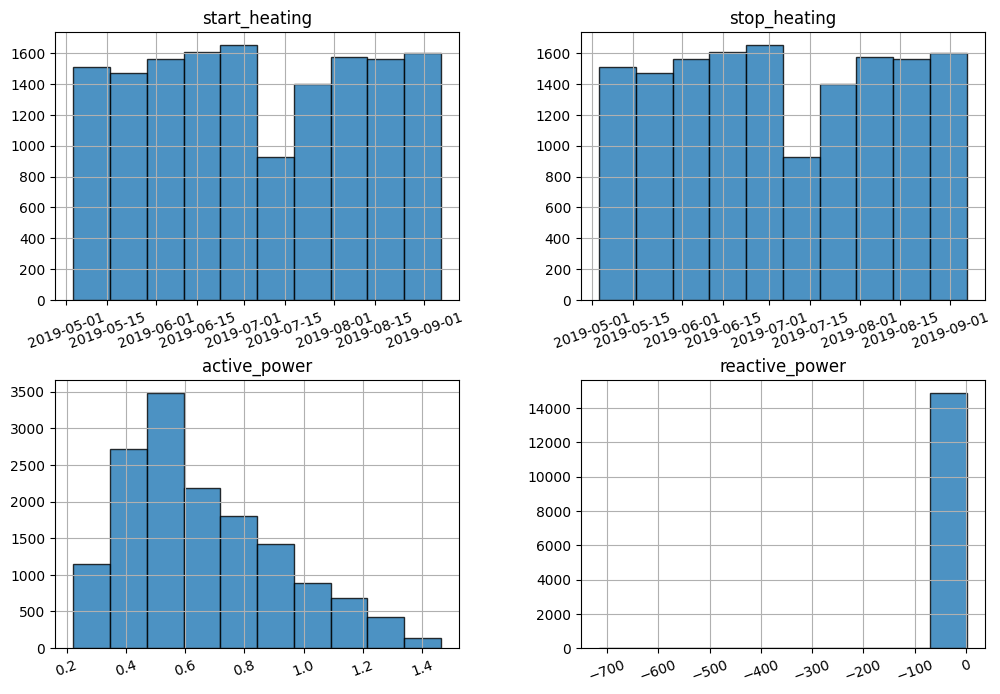

In [214]:
# получим первичную информацию
# применим 'about_df' к 'df_arc'
about_df(df_arc, hist_size=(12, 8), hist_xrot=20)

In [215]:
print('Период с', df_arc.start_heating.min(), 'по', df_arc.stop_heating.max())

Период с 2019-05-03 11:02:14 по 2019-09-06 17:26:15


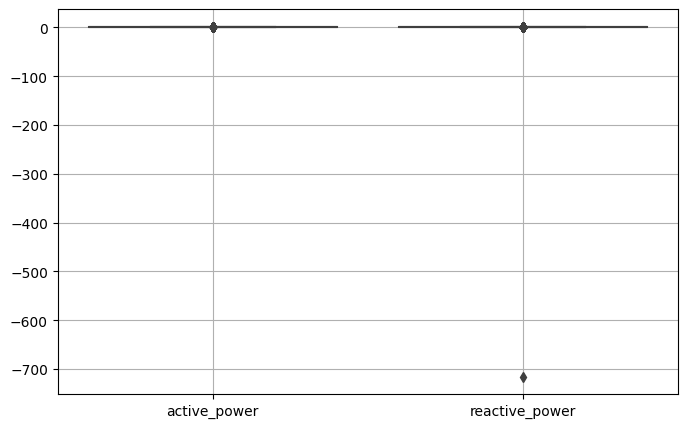

In [216]:
# выбросы в значениях мощности
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_arc.drop(columns='key'))
plt.grid(True)
plt.show()

Значение реактивной мощности -715.479924, явно выброс, необходимо уточнение у заказчика.

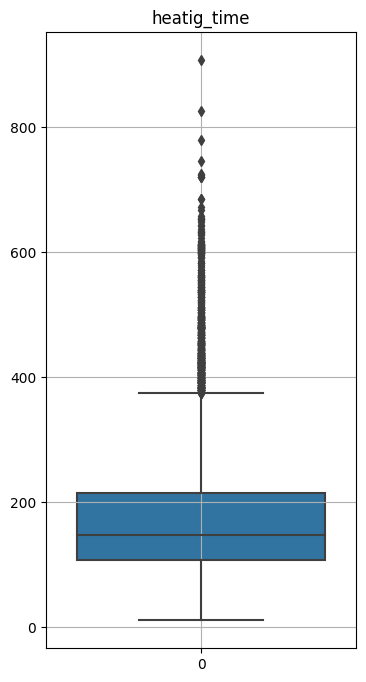

In [217]:
# длительность нагрева в секундах
df_arc['heatig_time'] = (df_arc['stop_heating'] - df_arc['start_heating']).astype('timedelta64[s]')

# выбросы в длительности нагрева
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_arc['heatig_time'])
plt.title('heatig_time')
plt.grid(True)
plt.show()

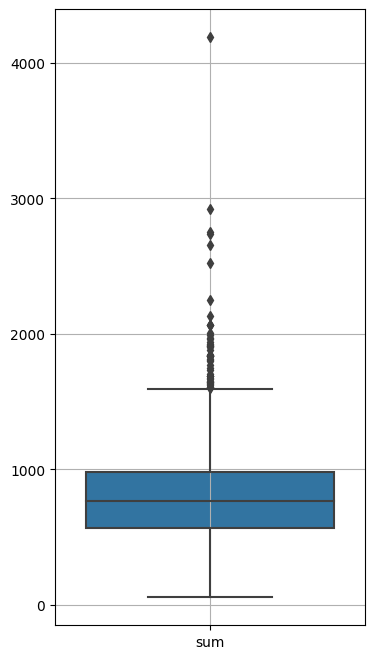

In [218]:
# выбросы в суммарной длительности нагрева
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_arc.groupby('key')['heatig_time'].aggregate(['sum']))
plt.grid(True)
plt.show()

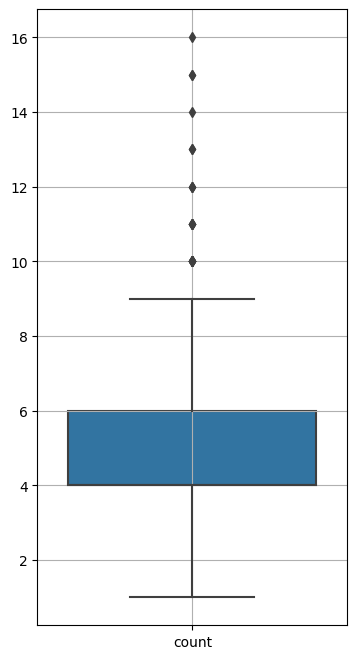

In [219]:
# выбросы в количестве нагревов
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_arc.groupby('key')['heatig_time'].aggregate(['count']))
plt.grid(True)
plt.show()

Необходимы уточнения являются ли большое количество нагревов или их высокая длительность ошибками или обнаруженные аномалии возможны на производстве.

In [220]:
print('количество партий:', len(df_arc['key'].unique()))
print('макс № партий:', df_arc['key'].max())

количество партий: 3214
макс № партий: 3241


## df_bulk — объём сыпучих материалов
<a name="s4"></a>

Выведем первые 5 строк:
-----------------------


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


-----------------------
Пропуски в столбцах:
-----------------------


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0


-----------------------
Описание значений по столбцам:
-----------------------


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



-----------------------
Корреляция признаков:
-----------------------


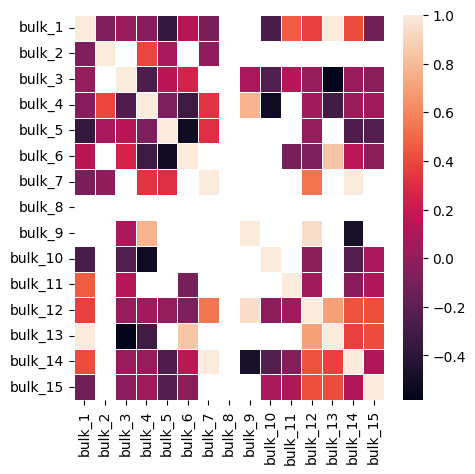


-----------------------
Распределение значений признаков:
-----------------------


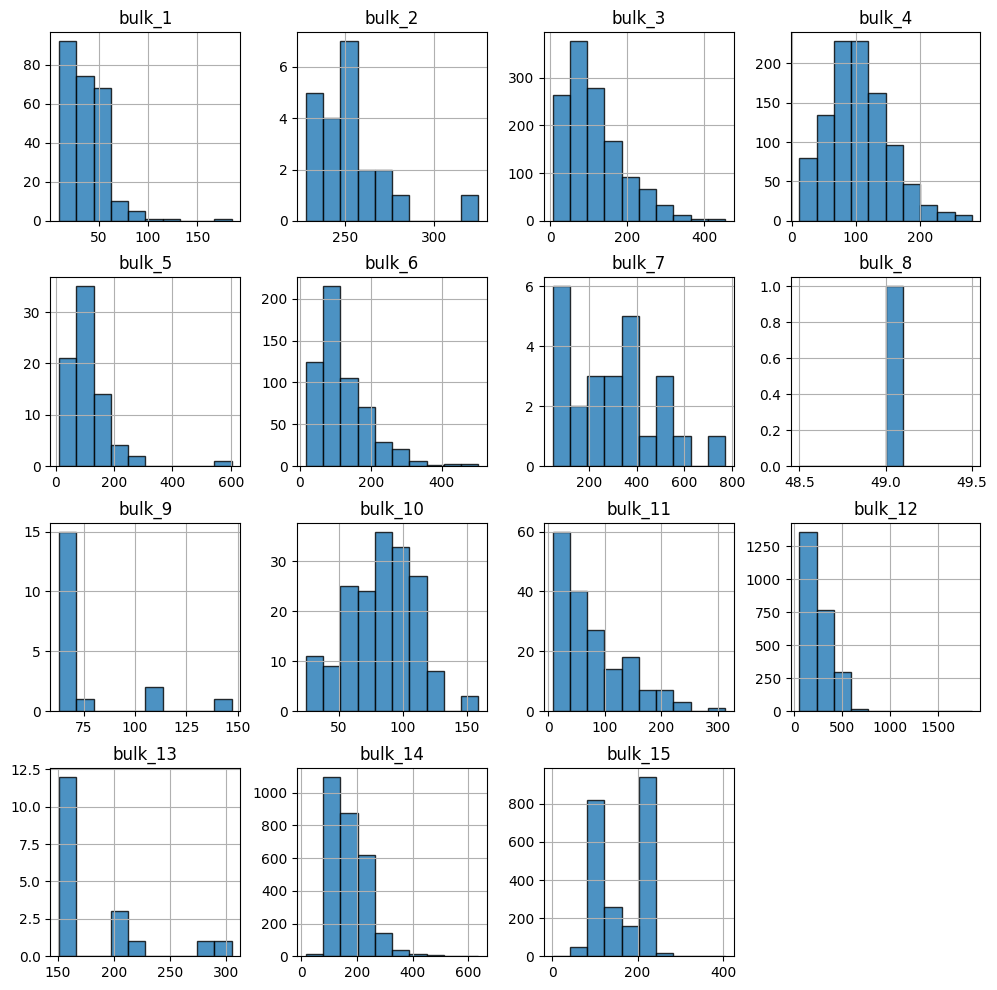

In [221]:
# получим первичную информацию
# применим 'about_df' к 'df_bulk'
about_df(df_bulk, hist_size=(12, 12))

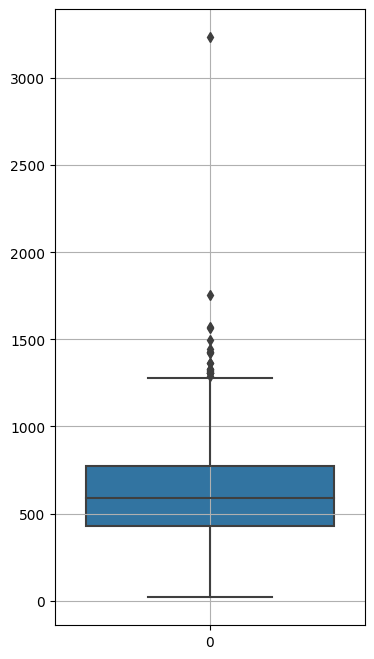

In [222]:
# суммарный объем сыпучих материалов
df_bulk['sum_bulk'] = df_bulk.drop(columns='key').sum(axis = 1)

# выбросы в суммарном объеме сыпучих материалов
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_bulk['sum_bulk'])
plt.grid(True)
plt.show()

Необходимы уточнения являются ли большие объемы сыпучих материалов ошибками или обнаруженные аномалии возможны на производстве.

In [223]:
print('количество партий:', len(df_bulk['key'].unique()))
print('макс № партий:', df_bulk['key'].max())

количество партий: 3129
макс № партий: 3241


## df_bulk_time — время подачи сыпучих материалов
<a name="s5"></a>

In [224]:
# получим первичную информацию
# применим 'about_df' к 'df_bulk_time'
about_df(df_bulk_time)

Выведем первые 5 строк:
-----------------------


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: 

None


-----------------------
Пропуски в столбцах:
-----------------------


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0

In [225]:
print('количество партий:', len(df_bulk_time['key'].unique()))
print('макс № партий:', df_bulk_time['key'].max())

количество партий: 3129
макс № партий: 3241


## df_gas — продувка сплава газом
<a name="s6"></a>

Выведем первые 5 строк:
-----------------------


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


-----------------------
Пропуски в столбцах:
-----------------------


key    0
gas    0
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0


-----------------------
Описание значений по столбцам:
-----------------------


,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040




-----------------------
Распределение значений признаков:
-----------------------


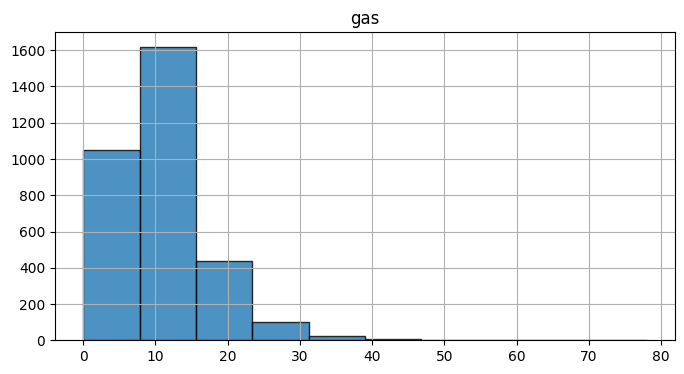

In [226]:
# получим первичную информацию
# применим 'about_df' к 'df_gas'
about_df(df_gas)

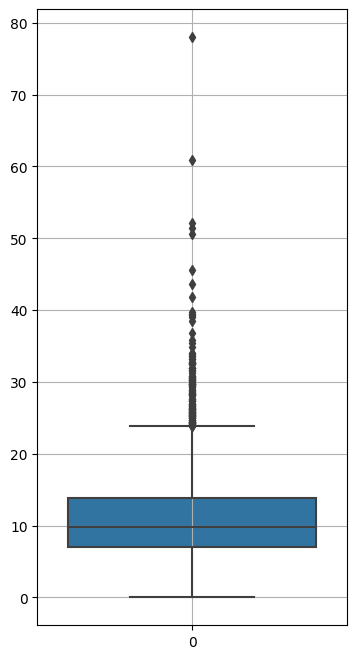

In [227]:
# выбросы в данных о продувке газом
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_gas['gas'])
plt.grid(True)
plt.show()

Имеются аномальные значения, необходимо уточнение.

---



In [228]:
print('количество партий:', len(df_gas['key'].unique()))
print('макс № партий:', df_gas['key'].max())

количество партий: 3239
макс № партий: 3241


##  df_temp — измерения температуры
<a name="s7"></a>

Выведем первые 5 строк:
-----------------------


,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   time         18092 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None


-----------------------
Пропуски в столбцах:
-----------------------


key               0
time              0
temperature    3427
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0


-----------------------
Описание значений по столбцам:
-----------------------


,temperature
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000




-----------------------
Распределение значений признаков:
-----------------------


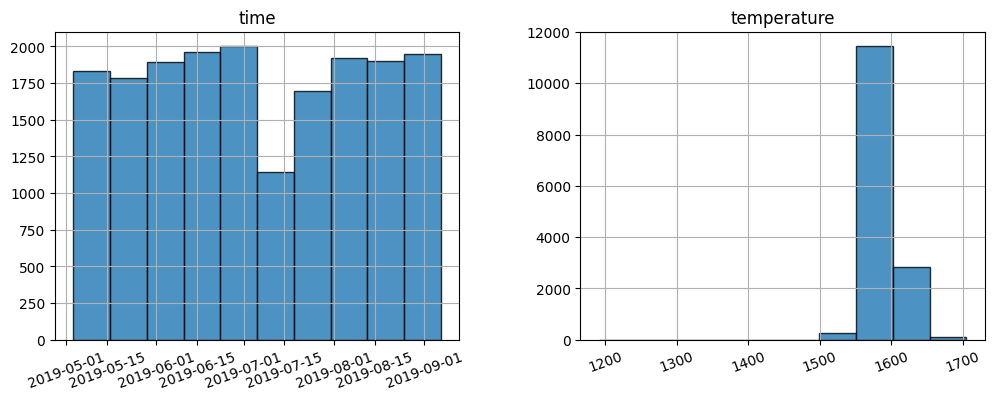

In [229]:
# получим первичную информацию
# применим 'about_df' к 'df_temp'
about_df(df_temp, hist_size=(12, 4), hist_xrot=20)

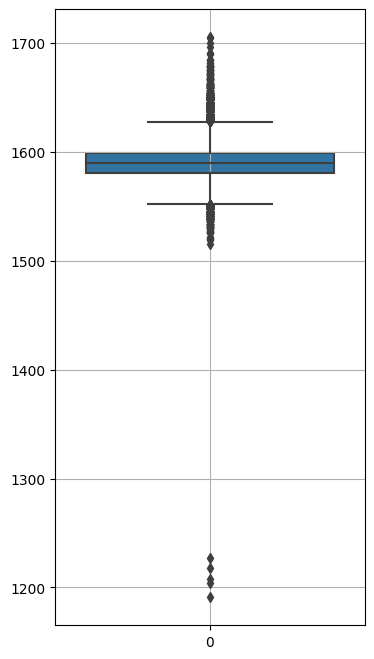

In [230]:
# выбросы в данных о температуре
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_temp['temperature'])
plt.grid(True)
plt.show()

Обнаружены аномальные значения температуры.

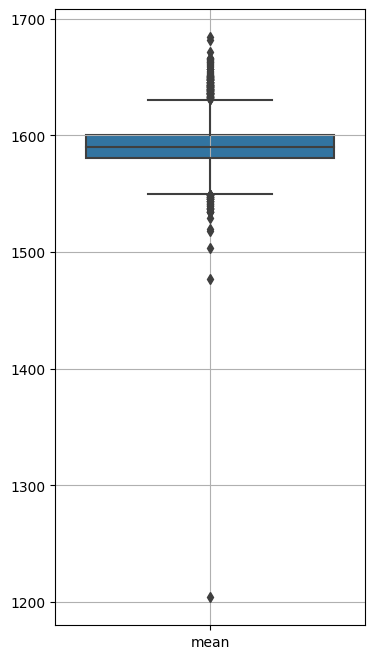

In [231]:
# выбросы в средних значениях температуры по партии
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_temp.groupby('key')['temperature'].aggregate(['mean']))
plt.grid(True)
plt.show()

In [232]:
print('Период с', df_temp.time.min(), 'по', df_temp.time.max())

Период с 2019-05-03 11:02:04 по 2019-09-06 17:30:05


In [233]:
print('количество партий:', len(df_temp['key'].unique()))
print('макс № партий:', df_temp['key'].max())

количество партий: 3216
макс № партий: 3241


## df_wire — объём проволочных материалов
<a name="s8"></a>

Выведем первые 5 строк:
-----------------------


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


-----------------------
Пропуски в столбцах:
-----------------------


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0


-----------------------
Описание значений по столбцам:
-----------------------


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



-----------------------
Корреляция признаков:
-----------------------


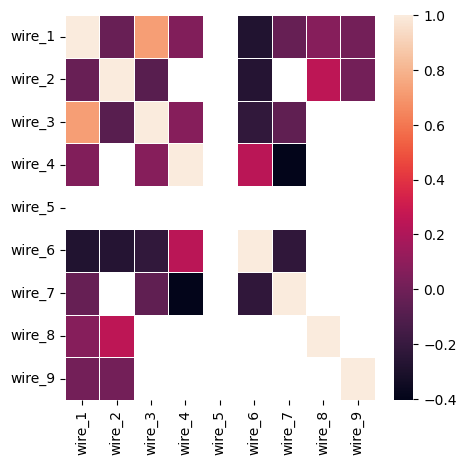


-----------------------
Распределение значений признаков:
-----------------------


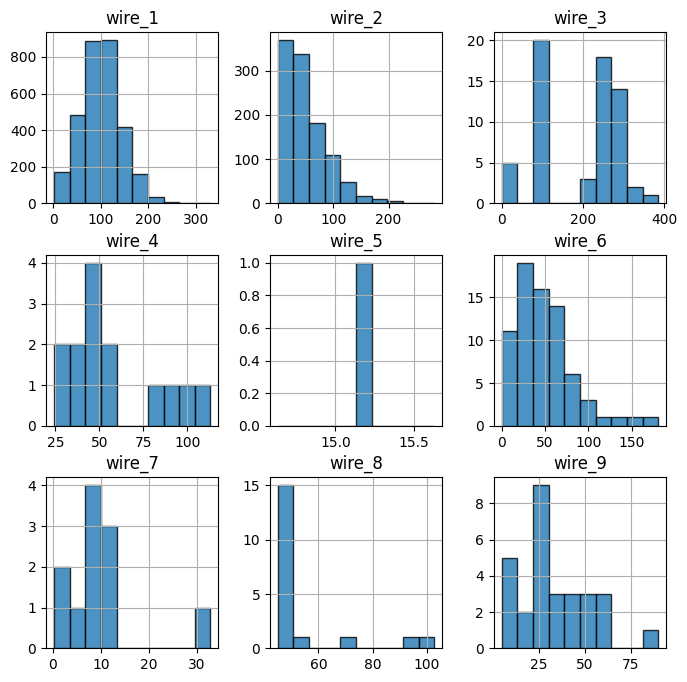

In [234]:
# получим первичную информацию
# примеим 'about_df' к 'df_wire'
about_df(df_wire, hist_size=(8,8))

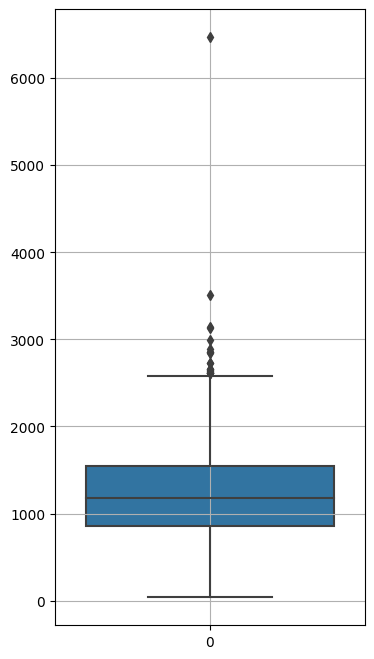

In [235]:
# суммарный объем проволочных материалов
df_wire['sum_wire'] = df_bulk.drop(columns='key').sum(axis = 1)

# аномалии в сумарном объеме проволочных материалов
plt.figure(figsize=(4, 8))
sns.boxplot(data=df_wire['sum_wire'])
plt.grid(True)
plt.show()

В суммарном объеме проволочных материалов также обнаружены выбросы.

In [236]:
print('количество партий:', len(df_wire['key'].unique()))
print('макс № партий:', df_wire['key'].max())

количество партий: 3081
макс № партий: 3241


## df_wire_time — время подачи проволочных материалов
<a name="s9"></a>

In [237]:
# получим первичную информацию
# применим 'about_df' к 'df_wire_time'
about_df(df_wire_time)

Выведем первые 5 строк:
-----------------------


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT



-----------------------
Выведем общую информацию:
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None


-----------------------
Пропуски в столбцах:
-----------------------


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


-----------------------
Дубликаты в данных:
-----------------------


0

In [238]:
print('количество партий:', len(df_wire_time['key'].unique()))
print('макс № партий:', df_wire_time['key'].max())

количество партий: 3081
макс № партий: 3241


## Выводы по исследованию
<a name="s10"></a>
Нам представлены данные различных этапов обработки и замеров характеристик 3_239 партий в период с 2019-05-03 по 2019-09-06. В ходе исследования обнаружено:
- >`data_arc_new.csv` — данные об электродах
  - 14_876 строк, информация о 3_214 партиях
  - столбцы: "key" - номер партии, "start_heating" - начало нагрева, "stop_heating" - конец нагрева,  "active_power" - активная мощность, "reactive_power" - реактивная мощность
  - обнаружены выбросы в "reactive_power", а также в суммарной длительности нагрева партии и длительности отдельных циклов нагрева партии
  - выбросы в количестве нагревов партии
  - пропусков и дубликатов не обнаружено


- >`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём)
  - 3_129 строк, количество партий: 3_129
  - столбцы: "key" - номер партии, "bulk_1,2,3...15" - видимо номер цикла на котором либо подаются сыпучие материалы в определенном объеме в данную партию, либо нет
  - большое количество пропусков, видимо не на каждом этапе в партию происходит подача сыпучих компонентов, то есть пропуск означает, что  на данном этапе материалы не подавались, возможно это зависит от результата химического анализа  на данном этапе
  - столбцы bulk_3,4,12,14,15 имеют меньше всего пропусков, возможно именно на этих этапах чаще всего добавляют сыпучие материалы, в отличие от остальных, где заполнены не более нескольких сотен значений, в bulk_8 вообще только одно значение не пропущено
  - исследовав суммарный объем добавленных сыпучих материалов по партиям обнаружены аномалии
  - дубликатов не обнаружено


- >`data_bulk_time_new.csv` — данные о времени подачи сыпучих материалов
  - данные аналогичны `data_bulk_new.csv` только в значениях столбцов "bulk_1,2,3..." даты и время подачи сыпучих материалов.
  - необходимо уточнение этапов процесса например: для партии №1 bulk_4 = 2019-05-03 11:28:48, а bulk_15 =  2019-05-03 11:10:43,  то есть bulk_15 наступает раньше bulk_4, когда для партии №2 ситуация обратная, необходимо уточнить что означают "bulk_1,2,3... и каков их порядок"
  - дубликатов не обнаружено

- >`data_gas_new.csv` — данные об объеме продувки сплава газом
  - 3_239 строк, количество партий: 3_239
  - столбцы: "key" - номер партии, "gas" - объем газа на партию
  - имеются аномальные значения в "gas"
  - пропусков и дубликатов не обнаружено

- >`data_temp_new.csv` — результаты измерения температуры
  - 18_092 строк, количество партий: 3_239
  - столбцы: "key" - номер партии, "temperature" - температура на этапе замера
  - пропуски в "temperature" - 3_427, данный признак целевой, целесообразнее всего не пытаться заполнить пропуски, а удалить их.
  - обнаружены аномальные значения температуры
  - дубликатов не обнаружено

- >`data_wire_new.csv` — данные о проволочных материалах (объём)
  - 3_081 строк, количество партий: 3_081
  - столбцы: "key" - номер партии, "wire_1,2,3...9" - видимо номер цикла на котором либо подаются проволочные материалы в определенном объеме в данную партию, либо нет
  - большое количество пропусков аналогично данным о сыпучих материалах, лишь wire_1 - 3_055 значений  и wire_2 - 1_079 значений, осатльные столбцы в большинстве значений имеют пропуски
  - исследовав суммарный объем добавленных проволочных материалов по партиям обнаружены аномалии
  - дубликатов не обнаружено


- >`data_wire_time_new.csv` — данные о проволочных материалах (время).
  - данные аналогичны `data_wire_new.csv` только в значениях столбцов "wire_1,2,3...9" даты и время подачи проволочных материалов.
  - дубликатов не обнаружено

- имеется не соответствие количества партий в зависимости  от этапа, возможно не каждая партия проходит каждый этап, либо данные утеряны

- аномалий в датах не замечено

- привели названия колонок к единому стилю, а признаки с датой привели к типу "datetime64"

- необходимо уточнить обнаруженные аномалии и технологические особенности этапов

---

# Вопросы к заказчику
1. Главный вопрос о цели проекта:
  - На каком этапе необходимо предсказать температуру?
  - Какой минимальной точности предсказания необходимо достигнуть? (максимально допустимая ошибка)
  - Как предсказание поможет экономить электроэнергию?  
  - Есть ли ограничения по времени обучения и предсказания?
  - Есть ли ограничения ресурсов на которых будет запускаться модель?

2. Возможно ли, что какие-то партии проходят не все этапы обработки, например в какую-то партию вообще не добавляются сыпучие или проволочные материалы, или какая-то партия не подвергалась нагреву электродами?

3. Необходимо уточнить возможные диапазоны значений для реактивной мощности, количестве нагревов партии, суммарном объеме подачи сыпучих и проволочных материалов, значения температуры и объема газа, для понимания природы аномальных значений. Возможны ли обнаруженные значения или это ошибки?

4. Что именно означают столбцы "bulk_1,2,3...15" и "wire_1,2,3...9", должны ли они иметь последовательный хронологический порядок? Как собираются данные этих столбцов? Необходимо понять природу пропусков в этих данных, которых большинство.


---

# Предобработка данных
<a name="s11"></a>

## Обработка пропусков
<a name="s13"></a>

Заполним пропуски в данных о температуре "0", объекты с пропусками не войдут в итоговые данные, температура - целевой признак, заполнять их не имеет смысла.

In [239]:
# заполним пропуски '0'
df_temp = df_temp.fillna(0)

## Удаление аномалий
<a name="s12"></a>

In [240]:
# аномалии в значениях температуры
anomaly_temp = df_temp.query('temperature < 1399')['key'].to_list()
df_temp = df_temp.query('key not in @anomaly_temp')

In [241]:
# аномалии в значениях реактивной мощности
anomaly_arc = df_arc.query('reactive_power < -715')['key'].to_list()
df_arc = df_arc.query('key not in @anomaly_arc')

## Подготовка данных
<a name="s14"></a>
Создание итогово  датасета, который будет использован для получения выборок, обучения и тестирования модели.

In [242]:
# целевой признак, конечная температура
# признак: температура на входе, общее время на ковш
df_temp_group = df_temp.groupby('key')[['temperature', 'time']].aggregate(['first', 'last']).reset_index()
df_temp_group.columns=['key', 'input_temp', 'output_temp', 'in', 'out']
df_temp_group['all_time']  = (df_temp_group['out'] - df_temp_group['in']).astype('timedelta64[s]')
df_temp_group = df_temp_group.drop(columns=['in', 'out'])

In [243]:
# признаки: сумма на партию длительности нагрева, мощности, работы,
# активной мощности, коэфицент мощности, количество нагревов
df_arc['work'] = df_arc['active_power'] * (df_arc['heatig_time'])
df_arc['full_power'] = (df_arc['active_power']**2 + df_arc['reactive_power']**2)**.5
df_arc['power_factor'] = df_arc['active_power'] / df_arc['full_power']

df_arc_sum = df_arc.groupby('key')[['heatig_time',
                                      'work',
                                      'power_factor',
                                      'full_power']].sum().reset_index()



df_arc_count = df_arc.groupby('key')['heatig_time'].aggregate(['count']).reset_index()
df_arc_count = df_arc_count.rename(columns={'count':'heating_score'})

df_arc_sum = df_arc_sum.merge(df_arc_count, how='inner', on='key')

In [244]:
# объем сыпучих материалов на ковш
# количество добавок
df_bulk['score_bulk'] = 15 - df_bulk.isna().sum(axis = 1)
df_bulk = df_bulk[['key', 'sum_bulk', 'score_bulk']]

In [245]:
# объем проволочных материалов на ковш
# количество добавок
# добавка "wire_1"
df_wire['score_wire'] = 9 - df_wire.isna().sum(axis = 1)
df_wire = df_wire[['key', 'wire_1', 'sum_wire', 'score_wire']]

In [246]:
# объединим данные в одну таблицу
df = pd.merge(df_temp_group, df_arc_sum, how='inner', on='key')
df = df.merge(df_bulk, how='inner', on='key')
df = df.merge(df_wire, how='inner', on='key')
df = df.merge(df_gas, how='inner', on='key')

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2324 non-null   int64  
 1   input_temp     2324 non-null   float64
 2   output_temp    2324 non-null   float64
 3   all_time       2324 non-null   float64
 4   heatig_time    2324 non-null   float64
 5   work           2324 non-null   float64
 6   power_factor   2324 non-null   float64
 7   full_power     2324 non-null   float64
 8   heating_score  2324 non-null   int64  
 9   sum_bulk       2324 non-null   float64
 10  score_bulk     2324 non-null   int64  
 11  wire_1         2301 non-null   float64
 12  sum_wire       2324 non-null   float64
 13  score_wire     2324 non-null   int64  
 14  gas            2324 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 290.5 KB


In [248]:
# удалим ковши с пропусками
df = df.dropna()

In [249]:
# признаки: относительное время, отношение количества добавок к количеству нагревов
df['relative_time'] = df['heatig_time'] / df['all_time']
df['rel_ingred_score'] = (df['score_bulk'] + df['score_wire']) / df['heating_score']

## Мультиколлинеарность
<a name="s15"></a>

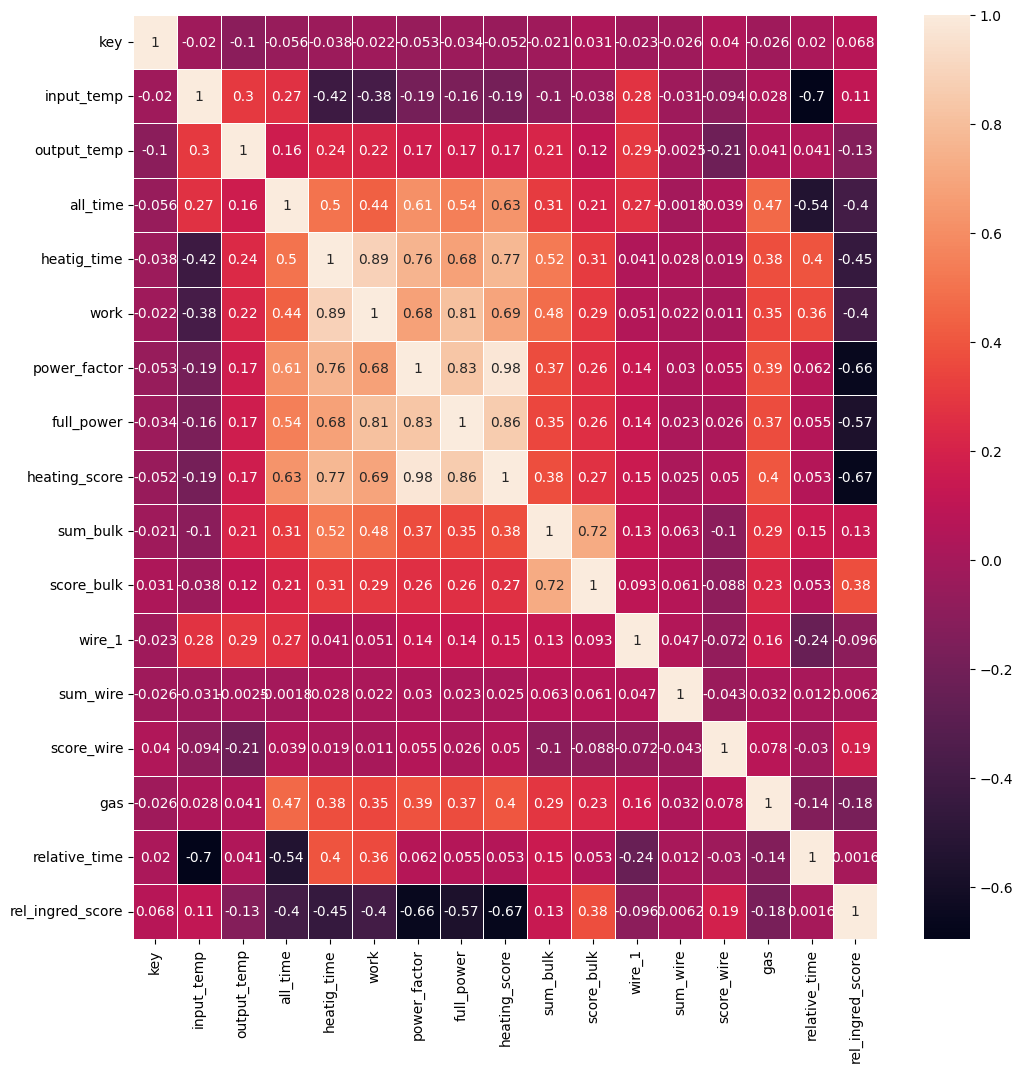

In [250]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(method='spearman'), annot=True, linewidth=.5)
plt.show()

In [251]:
# функция для удаления коррелирующих признков.
def drop_corr_feachers(data, corr_value):
  drop_list = []
  list_i = []
  for i in data.corr().index:
    for col in data.corr().columns:
      if abs(data.corr()[col][i]) >= corr_value and col != i:
        list_i.append(i)
        if col not in list_i:
            drop_list.append(col)
  data = data.drop(columns=drop_list)
  print('удален:', drop_list)
  return data

In [252]:
# применим drop_corr_feachers()
df = drop_corr_feachers(df, 0.9)

удален: ['work', 'heating_score']


## Итоги предобработки
<a name="s16"></a>
**В ходе предобработки:**
- удалили партии с пропусками
- удалили аномалии в значениях температуры и реактивной мощности
- создали итоговый датасет для подбора модели и ее гиперпараметров
-> сгенерировали признаки:
  - 'input_temp' - температура на входе
  -	'output_temp' - температура выхода, целевой
  -	'all_time' - общее время на партию
  -	'heatig_time' - время нагрева
  -	'work' - работа (активная мощность * время)
  -	'power_factor' - фактор мощности, отношение активной мощности к полной
  -	'full_power' - полная мощность
  -	'heating_score' - количество нагревов
  -	'sum_bulk' - общий объем сыпучих материалов
  -	'score_bulk' - количество сыпучих добавок
  -	'wire_1' - проволочная добавка wire_1
  -	'sum_wire' - общий объем проволочных материалов
  -	'score_wire' - количество проволочных  добавок
  -	'gas' - объем газа
  -	'relative_time' - отношение времени нагрева к общему времени
  -	'rel_ingred_score' - отношение количества добавок к количеству нагревов
- исследовали  мультиколлинеарность, удалили признаки с корреляцией выше  0.9: 'work' и 'heating_score'

---

# Модели
<a name="s17"></a>
Выбор модели и подбор гиперпараметров.

## Выборки
<a name="s18"></a>

In [253]:
rs = np.random.RandomState(80523)

In [254]:
# тестовая выборка 0.25 от общей
train, test = train_test_split(df, test_size=.25, random_state=rs)
print('train:', train.shape[0], 'test:', test.shape[0])

train: 1725 test: 576


In [255]:
# выделим целевой признак
X_train = train.drop(columns=['output_temp', 'key'])
y_train = train['output_temp']

X_test = test.drop(columns=['output_temp', 'key'])
y_test = test['output_temp']


print('train:', X_train.shape[0], 'test:', X_test.shape[0])

train: 1725 test: 576


## Подбор модели
<a name="s19"></a>

### LinearRegression

In [256]:
# ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=.25, random_state=rs)

In [257]:
# линейная регрессия
lr = LinearRegression()

scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)

print(scores)
print(scores.mean())

[-5.9873115  -5.94432263 -6.06246348 -6.07921236 -5.76454647]
-5.967571287851138


### RandomForestRegressor

In [258]:
%%time
# создадим, обучим и подберем параметры для RandomForestRegressor
rfr = RandomForestRegressor(random_state=rs)

parameters = {
    'n_estimators': range(10, 151, 20),
    'max_depth': range(1, 14, 2)
    }

grid = GridSearchCV(
    rfr,
    param_grid=parameters,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
    )

grid.fit(X_train, y_train)

print('Лучший результат:')
print('гиперпараметры: ', grid.best_params_)
print('MAE: ', grid.best_score_)

Лучший результат:
гиперпараметры:  {'max_depth': 11, 'n_estimators': 150}
MAE:  -5.984280887944981
CPU times: user 4.64 s, sys: 381 ms, total: 5.02 s
Wall time: 2min 37s


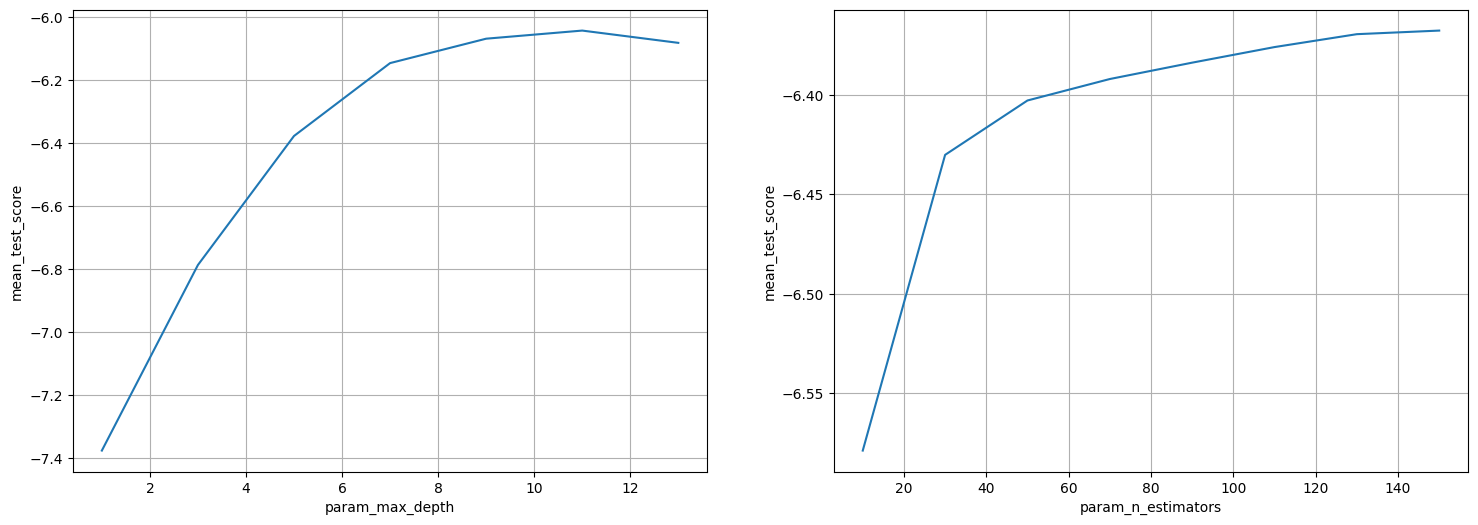

In [259]:
# построим графики
# зависимость 'param_max_depth' от 'param_n_estimators'
# зависимость 'mean_test_score' от 'param_n_estimators'

grid_res = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(1,2)
sns.lineplot(data=grid_res.groupby(
    'param_max_depth')['mean_test_score'].mean(), ax=ax[0])

sns.lineplot(data=grid_res.groupby(
    'param_n_estimators')['mean_test_score'].mean(), ax=ax[1])

ax[0].grid()
ax[1].grid()
fig.set_figheight(6)
fig.set_figwidth(18)
fig.show()

### LGBMRegressor

In [260]:
%%time
# создадим, обучим и подберем параметры для LGBMRegressor
lgb = LGBMRegressor(random_state=rs)

parameters = {'objective': ['poisson'],
              'learning_rate': [0.1],
              'max_depth': [1, 2, 3, 5],
              'n_estimators': range(200, 701, 50)
             }

grid = GridSearchCV(
    lgb,
    param_grid=parameters,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
    )

grid.fit(X_train, y_train)

print('Лучший результат:')
print('гиперпараметры: ', grid.best_params_)
print('MAE: ', grid.best_score_)

Лучший результат:
гиперпараметры:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'objective': 'poisson'}
MAE:  -6.009510544907168
CPU times: user 1.59 s, sys: 91.6 ms, total: 1.68 s
Wall time: 33.3 s


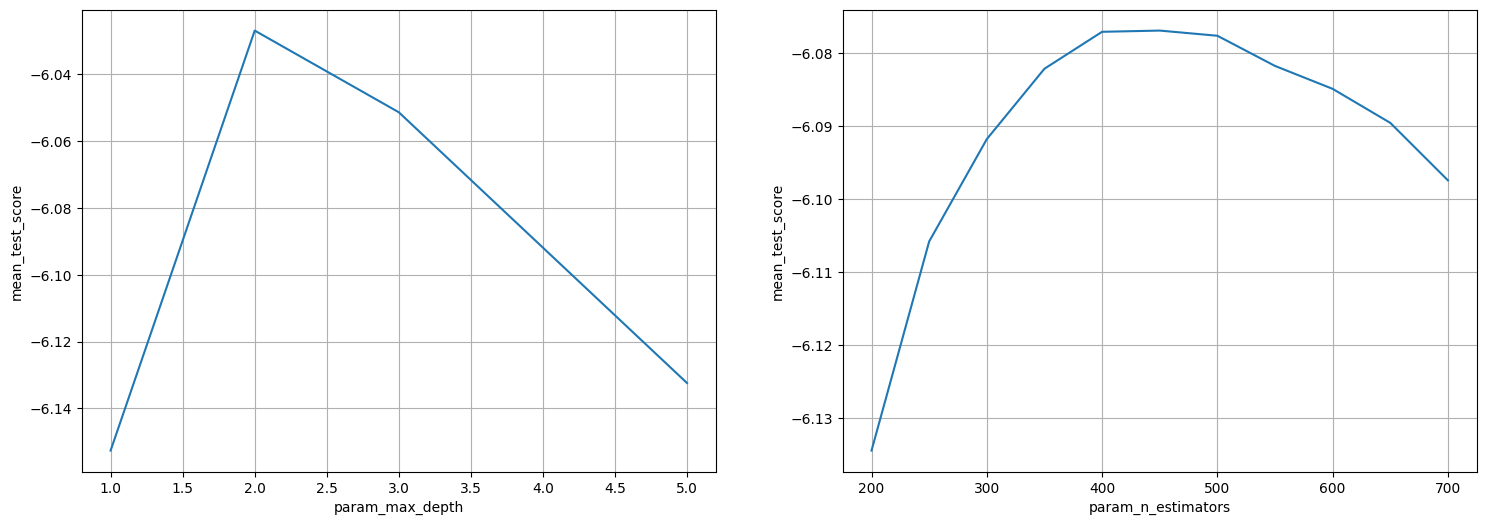

In [261]:
# построим графики
# зависимость 'mean_test_score' от 'param_max_depth'
# зависимость 'mean_test_score' от 'param_n_estimators'

grid_res = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(1,2)
sns.lineplot(data=grid_res.groupby(
    'param_max_depth')['mean_test_score'].mean(), ax=ax[0])

sns.lineplot(data=grid_res.groupby(
    'param_n_estimators')['mean_test_score'].mean(), ax=ax[1])

ax[0].grid()
ax[1].grid()
fig.set_figheight(6)
fig.set_figwidth(18)
fig.show()

##  Анализ важности признаков
<a name="s20"></a>

In [262]:
# обучим модель
lgb = LGBMRegressor(objective='poisson',
                    learning_rate=0.1,
                    max_depth=2,
                    n_estimators=400,
                    random_state=rs)

lgb.fit(X_train, y_train)

LGBMRegressor(max_depth=2, n_estimators=400, objective='poisson',
              random_state=RandomState(MT19937) at 0x7DF6DE389F40)

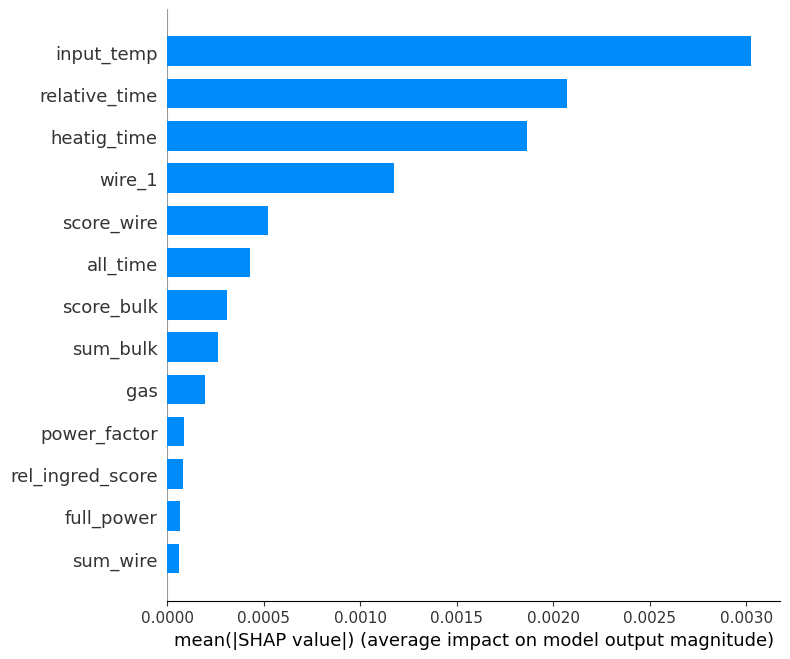

In [263]:
# используем библиотеку shap для анализа
shap_values = shap.TreeExplainer(lgb).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(lgb).shap_interaction_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


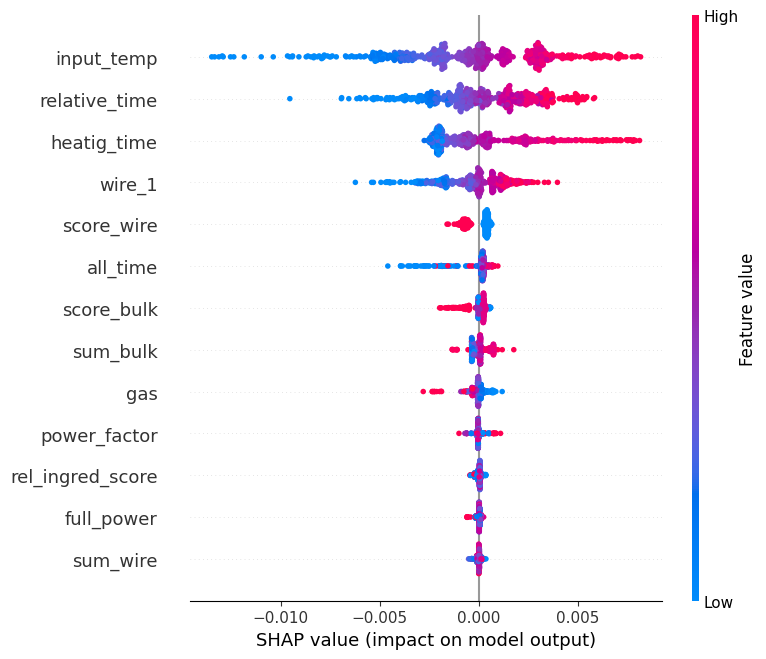

In [264]:
shap.summary_plot(shap_values, X_test)

In [265]:
shap.initjs()
e = shap.TreeExplainer(lgb)
t = e.shap_values(X_test)
shap.force_plot(e.expected_value, shap_values, X_test)

## Итог
<a name="s21"></a>
**На этапе моделирования:**
- сгенерировали обучающую и тестовую выборки
- подбирали модели основанные на разных подходах:
  - LinearRegression - обучали с помощью кросс-валидации
  - RandomForestRegressor - обучали и подбирали гиперпараметры с помощью GridSearchCV
  - LGBMRegressor - обучали и подбирали гиперпараметры спомощью GridSearchCV
- контролировали переобучение с помощью графиков
- на тестировние выводим LGBMRegressor с гиперпараметрми:`objective='poisson', learning_rate=0.1, max_depth=2, n_estimators=450`, MAE на валидации: 6.0
- провели анализ важности признаков с помощью "shap", выявили, что наибольшее влияние на целевой признак оказывают температура на входе - 'input_temp'  и время нагрева - 'heatig_time' или отношение времени нагрева ко всему времени легирования, наименьшее влияние оказывают полная мощность - 'full_power' и общий объем проволочных материалов - 'sum_wire', их можно исключить.

---

# Тестирование модели
<a name="s22"></a>

In [266]:
lgb = LGBMRegressor(objective='poisson',
                    learning_rate=0.1,
                    max_depth=2,
                    n_estimators=400,
                    random_state=rs)

lgb.fit(X_train, y_train)
predict = lgb.predict(X_test)
print('MAE test:', mean_absolute_error(y_test, predict))

MAE test: 6.229184832143937


---

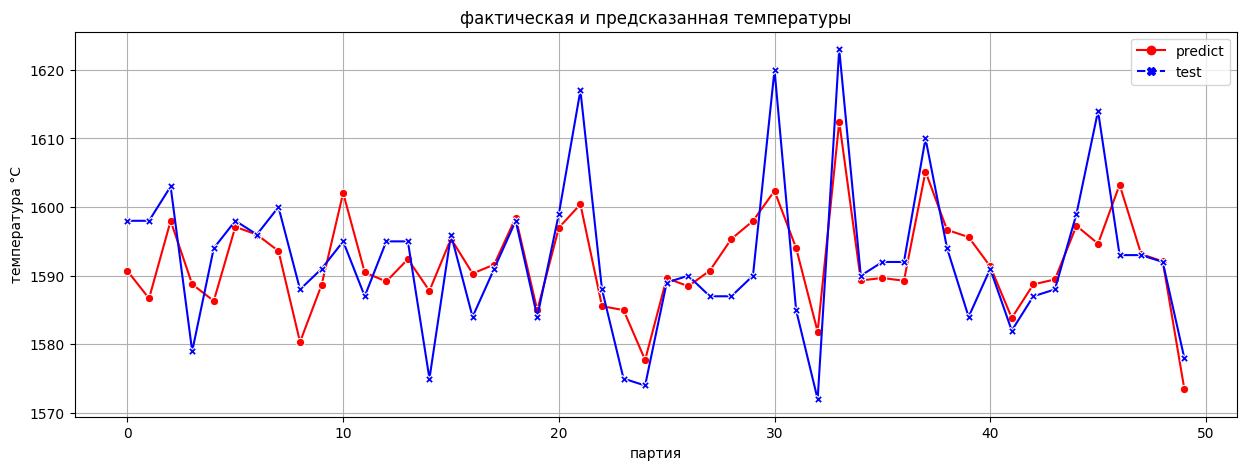

In [267]:
# предсказания и реальные значения на графике
test_predict = pd.merge(pd.DataFrame(predict, index=y_test.index)[:50],
                        y_test[:50], left_index=True, right_index=True).reset_index(drop=True)
test_predict.columns=['predict', 'test']

plt.subplots(figsize=(15, 5))
sns.lineplot(test_predict, palette=['red', 'blue'], markers=True).lines[1].set_linestyle("-")
plt.title('фактическая и предсказанная температуры')
plt.xlabel('партия')
plt.ylabel('температура °C')
plt.grid(True)
plt.show()

# Выводы:
<a name="s23"></a>

1. исследовав данные:
 - ознакомились с данными о представленном этапе обработки стали
 - обнаружили пропуски и аномалии в значениях
 - ознакомились с распределением значений
 - составили план работы
 - провели уточнение цели нашей работы и особенностей технологического процесса

2. в ходе предобработки:
 - отобрали подходящие партии
 - удалили пропуски
 -> сгенерировали признаки, рассчитывали их в сумме на партию (ковш):
    - 'input_temp' - температура на входе, удалили аномалии температура < 1400
    -	'output_temp' - температура выхода, целевой, удалили аномалии температура < 1400
    -	'all_time' - общее время на партию
    -	'heatig_time' - время нагрева
    -	'work' - работа (активная мощность * время) удален из-за высокой корреляции с 'heatig_time'
    -	'power_factor' - фактор мощности, отношение активной мощности к полной
    -	'full_power' - полная мощность, корень квадратный из суммы квадратов активной и реактивной мощности
    -	'heating_score' - количество нагревов,  удален из-за высокой корреляции с 'power_factor'
    -	'sum_bulk' - общий объем сыпучих материалов
    -	'score_bulk' - количество сыпучих добавок
    -	'wire_1' - проволочная добавка wire_1
    -	'sum_wire' - общий объем проволочных материалов
    -	'score_wire' - количество проволочных  добавок
    -	'gas' - объем газа
    -	'relative_time' - отношение времени нагрева к общему времени
    -	'rel_ingred_score' - отношение количества добавок к количеству нагревов
    - удаление выбросов (температуры и реактивной мощности) в обучающей выборке вело к ухудшению модели
 - исследовали мультиколлинеарность
 - подготовили данные к этапу моделирования
3. выбор модели и тестирование:
 - удалось подобрать модель: LGBMRegressor с гиперпараметрми:`objective='poisson', learning_rate=0.1, max_depth=2, n_estimators=450, random_state=rs, rs= np.random.RandomState(80523)`, MAE на тесте: 6.22
 - провели анализ важности признков с помощью "shap"

4. сложности:</br> статистически почти во всех признаках есть выбросы, по информации заказчика такие значения возможны, аномалии – не ошибки, однако они затрудняют работу модели; из этого следует потребность в большем количестве данных, возможно это решит проблему и модель лучше адаптируется, либо весь процесс легирования недостаточно стабилен, а его "предсказуемость" также существенно влияет на результат

Заключение:</br>
Наша модель LGBMRegressor с MAE на тесте: 6.22, означает, что в среднем модель ошибается на 6.22 градуса, эта точность соответствует условиям заказчика.

После анализа важности признаков, выявили, что наибольшее влияние на температуру выхода влияет температура партии на входе и время нагрева, для не допускания перегрева следует обратить внимание именно на эти показания, если их возможно контролировать и регулировать. Однако выводы сделаны лишь по представленным  данным определенного этапа общего процесса обработки стали, возможно влияние оказывают факторы недоступные в представленных данных. Для более подробного исследования факторов влияющих на перегрев необходимо исследование по большему количеству данных (например данные о хим.составе), описывающих процесс более детально.

Из графика выше хорошо видно, что модель улавливает пик, но недостаточно хорошо отрабатывает его, из этого еще раз можно сделать вывод, что есть еще не доступные нам факторы влияющие на  перегрев помимо входной температуры и времени нагрева, либо же процесс в принципе недостаточно стабилен, тогда поиск причин будет затруднителен.